In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix,\
precision_score,recall_score,roc_curve, mean_squared_error

from tqdm.auto import tqdm
import scipy.sparse    # 稀疏矩阵的处理
import pickle
import gc


# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
sample_submit = pd.read_csv('input/sample_submit.csv')

# **EDA**

In [3]:
# 数据集维度
train.shape,test.shape

((150000, 53), (30000, 52))

In [4]:
# 数据类型
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    150000 non-null  int64  
 1   main_account_loan_no           150000 non-null  int64  
 2   main_account_active_loan_no    150000 non-null  int64  
 3   main_account_overdue_no        150000 non-null  int64  
 4   main_account_outstanding_loan  150000 non-null  int64  
 5   main_account_sanction_loan     150000 non-null  int64  
 6   main_account_disbursed_loan    150000 non-null  int64  
 7   sub_account_loan_no            150000 non-null  int64  
 8   sub_account_active_loan_no     150000 non-null  int64  
 9   sub_account_overdue_no         150000 non-null  int64  
 10  sub_account_outstanding_loan   150000 non-null  int64  
 11  sub_account_sanction_loan      150000 non-null  int64  
 12  sub_account_disbursed_loan    

In [5]:
train['loan_default'].value_counts()

0    123455
1     26545
Name: loan_default, dtype: int64

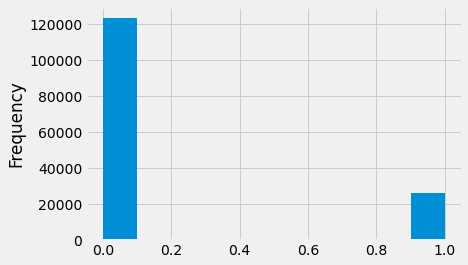

In [6]:
train['loan_default'].plot.hist();

In [7]:
len(train.loc[train['loan_default']==1,'loan_default'])\
/len(train['loan_default'])

0.17696666666666666

In [8]:
id = 'customer_id'
target_name = 'loan_default'

In [9]:
train.head(3).append(train.tail(3))

,customer_id,main_account_loan_no,main_account_active_loan_no,main_account_overdue_no,main_account_outstanding_loan,main_account_sanction_loan,main_account_disbursed_loan,sub_account_loan_no,sub_account_active_loan_no,sub_account_overdue_no,...,main_account_tenure,sub_account_tenure,disburse_to_sactioned_ratio,active_to_inactive_act_ratio,year_of_birth,disbursed_date,Credit_level,employment_type,age,loan_default
0,105691,4,3,0,384989,666207,666207,0,0,0,...,81,0,1.00,2.50,1968,2019,1,0,51,0
1,24938,7,2,0,268670,387994,387994,0,0,0,...,161,0,1.00,1.33,1992,2019,9,0,27,0
2,104389,5,4,1,3519013,3613854,3576048,0,0,0,...,3576048,0,0.99,3.00,1991,2019,13,1,28,0
149997,1125,21,4,0,60522,119000,119000,0,0,0,...,3,0,1.00,1.22,1981,2019,7,0,38,0
149998,4752,0,0,0,0,0,0,0,0,0,...,0,0,1.00,1.00,1988,2019,-1,0,31,0
149999,31397,0,0,0,0,0,0,0,0,0,...,0,0,1.00,1.00,1988,2019,-1,1,31,0


In [10]:
# 总体粗略的查看数据集各个特征的一些基本统计量
train.describe()

,customer_id,main_account_loan_no,main_account_active_loan_no,main_account_overdue_no,main_account_outstanding_loan,main_account_sanction_loan,main_account_disbursed_loan,sub_account_loan_no,sub_account_active_loan_no,sub_account_overdue_no,...,main_account_tenure,sub_account_tenure,disburse_to_sactioned_ratio,active_to_inactive_act_ratio,year_of_birth,disbursed_date,Credit_level,employment_type,age,loan_default
count,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,1.500000e+05,1.500000e+05,150000.000000,150000.000000,150000.000000,...,1.500000e+05,1.500000e+05,1.500000e+05,150000.000000,150000.000000,150000.0,150000.000000,150000.000000,150000.000000,150000.000000
mean,99944.368847,2.447133,1.045500,0.153427,1.670825e+05,2.225586e+05,2.221730e+05,0.060133,0.027967,0.007293,...,5.169842e+04,2.773138e+03,6.506428e+02,1.438740,1984.867900,2019.0,3.132360,0.487507,34.132100,0.176967
std,57629.110557,5.197172,1.952708,0.542496,9.808619e+05,2.840313e+06,2.844075e+06,0.652912,0.325185,0.111236,...,2.614563e+06,1.043622e+05,1.312314e+05,0.789844,9.813379,0.0,5.268384,0.561527,9.813379,0.381642
min,0.000000,0.000000,0.000000,0.000000,-6.678296e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1950.000000,2019.0,-1.000000,0.000000,18.000000,0.000000
25%,50069.750000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,1.000000e+00,1.000000,1978.000000,2019.0,-1.000000,0.000000,26.000000,0.000000
50%,99887.500000,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,1.000000e+00,1.000000,1987.000000,2019.0,-1.000000,0.000000,32.000000,0.000000
75%,149916.500000,3.000000,1.000000,0.000000,3.545900e+04,6.360000e+04,6.150850e+04,0.000000,0.000000,0.000000,...,2.500000e+01,0.000000e+00,1.000000e+00,1.670000,1993.000000,2019.0,8.000000,1.000000,41.000000,0.000000
max,199716.000000,354.000000,144.000000,23.000000,9.652492e+07,1.000000e+09,1.000000e+09,52.000000,36.000000,7.000000,...,1.000000e+09,1.980000e+07,5.000000e+07,18.000000,2001.000000,2019.0,13.000000,2.000000,69.000000,1.000000


# 建模

In [11]:
X = train.drop(['customer_id','mobileno_flag', 'idcard_flag', 'disbursed_date','passport_flag','Driving_flag','loan_default',],axis=1)
y = train['loan_default']
X_test = test.drop(['customer_id','mobileno_flag', 'idcard_flag', 'disbursed_date','passport_flag','Driving_flag'],axis=1)

In [12]:
def prob_to_label(x,threshold):
    labels = x.copy()
    labels[labels<threshold]=0
    labels[labels>=threshold]=1
    return labels

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def feval_RMSPE(lgb_train,preds):
    y_true = lgb_train.get_label()
    return 'RMSPE', round(rmspe(y_true, preds),5), False



def floss(y_true,y_pred, beta=1, log_like=False):
    EPS = 1e-10
    # print(prediction)
    N = y_pred.size
    TP = (y_pred * y_true).sum()
#     TP = np.logical_and(prediction,target).sum()
    H = beta * y_true.sum() + y_pred.sum()
    fmeasure = (1 + beta) * TP / (H + EPS)
    if log_like:
        floss_ = -torch.log(fmeasure)
    else:
        floss_  = (1 - fmeasure)
    return floss_

def floss_macro(y_true, y_pred, beta=1, log_like=False):
    EPS = 1e-10
    y_pred_inv = np.logical_not(y_pred)
    y_true_inv = np.logical_not(y_true)
    
    TP_0 = (y_pred_inv * y_true_inv).sum()
    H_0 = beta * y_true_inv.sum() + y_pred_inv.sum()
    fmeasure_0 = (1 + beta) * TP_0 / (H_0 + EPS)
    
    TP_1 = (y_pred * y_true).sum()
    H_1 = beta * y_true.sum() + y_pred.sum()
    fmeasure_1 = (1 + beta) * TP_1 / (H_1 + EPS)
    
    fmeasure = (fmeasure_0 + fmeasure_1)/2
    if log_like:
        floss_ = -torch.log(fmeasure)
    else:
        floss_ = - fmeasure
    return floss_

    
def f1_score_custom(y_true, y_pred):
    y_pred = y_pred.round()
    return 'f1', f1_score(y_true, y_pred,average='macro'), True

def feval_f1(lgb_train, preds, threshold):
    y_true = lgb_train.get_label()
    y_pred = prob_to_label(preds,threshold=threshold)
    return 'f1', round(floss(y_true,y_pred),5), False

def feval_f1_macro(preds,lgb_train):  #注意preds要放前面，我也不知道为什么，否则会报错ndarray has no...get_label()
    y_true = lgb_train.get_label()
    y_pred = prob_to_label(preds,threshold=threshold)
    return 'f1_macro', round(floss_macro(y_true,y_pred),5), False

def feval_f1_macro_2(preds,lgb_train):
    y_true = lgb_train.get_label()
    y_pred = prob_to_label(preds,threshold=threshold)
    # 基于sklearn 的f1_score实现，速度较慢
    return 'f1_macro_sklearn', -round(f1_score(y_true,y_pred,average='macro'),5), False

def feval_f1_macro_xgb(preds,train_matrix):
    y_true = train_matrix.get_label()
    y_pred = prob_to_label(preds,threshold=threshold)
    return 'f1_macro', round(floss_macro(y_true,y_pred),5)

In [36]:
lgb_params = {
            # Parameters_a 
            'objective': 'binary',
            'boosting': 'gbdt', # 'dart'
            'metric': 'auc',
            # 'num_iterations':100,  # default=100,构建的树的数量
            # 'max_bin': 255,
            'learning_rate': 0.01,
            'early_stopping_rounds':200, 
            
            # Parameters_b
            'num_leaves': 2 ** 7,  # default = 31(2**5-1)
            'max_depth': 10,
            # 'min_data_in_leaf': 20 ,# default = 20
            'min_child_weight': 5,
            'bagging_fraction': 0.9,
            'bagging_freq': 4,
            'feature_fraction': 0.9,
            # 'lambda_l1':0,
            'lambda_l2': 10,
            # 'min_gain_to_split':0,
            
            # Parameters_c
            'n_jobs': -1, # 'n_jobs'
#             'device':cpu,  # gpu, cuda
            'seed': 2021,
            'verbosity': -1,
            # Objective Paras
            # 'is_unbalance':'false'  # true会把负样本的权重设为：正样本数/负样本数。
        }

xgb_params={'booster': 'gbtree',
            'objective': 'binary:logistic',
            'eval_metric':'auc',
            'max_depth':7, 
            'gamma':1,
            'lambda': 10,
            'eta':0.04, # default=0.3
            'colsample_bytree':0.7, # 生成树时进行的列采样
            'subsample':0.7, # 随机采样训练样本 
#             'binary':'logistic',
            'tree_method':'exact',#
            'nthread':-1,
            'seed':2021
}

cat_params = {'learning_rate': 0.05,
              'depth': 7,
              'l2_leaf_reg': 10,
              'bootstrap_type': 'Bernoulli',
              'od_type': 'Iter',
              'od_wait': 50,
              'random_seed': 2021,
              'allow_writing_files': False
}

In [37]:
oof = pd.DataFrame()                 # out-of-fold result
cv_scores = []
cv_scores_2 = []
cv_scores_xgb = []
cv_scores_xgb_2 = []
cv_scores_cat = []
cv_scores_cat_2 = []

f1_list = []
precision_list = []
recall_list = []
confusion_matrix_list = []

models = []                          # models
scores = 0.0                         # validation score
threshold = 0.25

# thresholds = [0.238,0.239,0.240,0.241,0.242,0.243,0.244,0.245,
#               0.246,0.247,0.248, 0.249,0.250,0.251,0.252,0.253]

def cv_model(clf, X, y, clf_name):
    folds = 5
    seed = 2021
    kf = KFold(n_splits=folds, random_state=seed, shuffle=True)

    for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
        print("Fold :", fold+1)
        # create dataset
        X_train, y_train = X.loc[trn_idx], y[trn_idx]
        X_valid, y_valid = X.loc[val_idx], y[val_idx]
        
        if clf_name == 'lgb':
#             weights = y_train + 1 
            train_matrix = clf.Dataset(X_train,y_train)
#             weights = y_valid + 1 
            valid_matrix = clf.Dataset(X_valid,y_valid,reference = train_matrix)

            # model 
            model = clf.train(params=lgb_params,  # bayes_lgb_params
                               train_set=train_matrix,
                               valid_sets=[train_matrix, valid_matrix],
                               num_boost_round=5000,
                               feval = feval_f1_macro,
#                                fobj= feval_floss_macro_2,
                               verbose_eval=200,
        #                       categorical_feature = ['Driving_flag']        
                             )
            # validation 
            
            y_pred = model.predict(X_valid, num_iteration=model.best_iteration)            
#             cv_scores.append(roc_auc_score(y_valid, y_pred))
            y_pred = prob_to_label(y_pred,threshold)

#         #     cv_scores.append(roc_auc_score(y_valid, y_pred))
            cv_scores.append(f1_score(y_valid, y_pred,average='macro'))
            cv_scores_2.append(f1_score(y_valid, y_pred,average='micro'))
        
            f1 = f1_score(y_valid,y_pred,average='macro')
            f1_list.append(f1)
            
            precision = precision_score(y_valid,y_pred)
            precision_list.append(precision)
            
            recall = recall_score(y_valid,y_pred)
            recall_list.append(recall)
            
            confusion_m=confusion_matrix(y_valid,y_pred)
            confusion_matrix_list.append(confusion_m)

            models.append(model)
            print("*" * 100)
            
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(X_train, y_train)
            valid_matrix = clf.DMatrix(X_valid, y_valid)
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]

            model = clf.train(xgb_params,
                              train_matrix,
                              num_boost_round=50000,
                              evals=watchlist,
#                               feval=feval_floss_macro_xgb,
                              verbose_eval=200,
                              early_stopping_rounds=200)
            
            
            y_pred = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            
            y_pred = prob_to_label(y_pred,threshold)
            
            cv_scores.append(f1_score(y_valid, y_pred,average='macro'))
            cv_scores_2.append(f1_score(y_valid, y_pred,average='micro'))

            f1 = f1_score(y_valid,y_pred,average='macro')
            f1_list.append(f1)
            
            precision = precision_score(y_valid,y_pred)
            precision_list.append(precision)
            
            recall = recall_score(y_valid,y_pred)
            recall_list.append(recall)
            
#             confusion_matrix=confusion_matrix(y_valid,y_pred)
#             print(confusion_matrix)
            
            models.append(model)
            print("*" * 100)
#             test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)

        if clf_name == "cat":
            model = clf(iterations=20000, **cat_params)
            model.fit(X_train, y_train,
                      eval_set=(X_valid, y_valid),
#                       cat_features=[],
                      use_best_model=True,
#                       eval_metric = feval_floss_macro,
                      verbose=500)
            
            y_pred  = model.predict(X_valid)
            y_pred = prob_to_label(y_pred,threshold)
            cv_scores_cat.append(f1_score(y_valid, y_pred,average='macro'))
            cv_scores_cat_2.append(f1_score(y_valid, y_pred,average='micro'))
            models.append(model)
            print("*" * 100)
#             test_pred = model.predict(test_x)

    print('cv_score: ',cv_scores)    
    print('avg_cv_score: ', np.average(np.array(cv_scores)))

In [38]:
models = []
def cv_model_with_pridict(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train_prediction = np.zeros(train_x.shape[0])
    test_prediction = np.zeros(test_x.shape[0])

    cv_scores = []
    target_arr = np.zeros(len(test_x))

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = lgb_params
            
            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # 因为已经predict了，所以models.append仅为了后面查看importance
            models.append(model)
            print("*" * 100)
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': -1,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred += model.predict(test_x , ntree_limit=model.best_ntree_limit)
            
            models.append(model)
            
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            models.append(model)
            print("*" * 100)
            
        train_prediction[valid_index] = val_pred
        test_prediction += test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        
        print(cv_scores)
        
    print("%s_score_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train_prediction, test_prediction

In [39]:
def lgb_model_with_predict(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model_with_pridict(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model_with_predict(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model_with_pridict(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model_with_predict(x_train, y_train, x_test):
    cat_train, cat_test = cv_model_with_pridict(CatBoostRegressor, x_train, y_train, x_test, "cat")

def lgb_model(x_train, y_train):
    lgb_train = cv_model(lgb, x_train, y_train, "lgb")
    return lgb_train

def xgb_model(x_train, y_train):
    xgb_train = cv_model(xgb, x_train, y_train, "xgb")
    return xgb_train

def cat_model(x_train, y_train):
    cat_train = cv_model(CatBoostRegressor, x_train, y_train,"cat")
    return cat_train

In [40]:
%%time
lgb_train = lgb_model(X, y)
# xgb_train = xgb_model(X, y)
# cat_train = cat_model(X, y)

Fold : 1
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.708341	training's f1_macro: -0.60006	valid_1's auc: 0.656145	valid_1's f1_macro: -0.55892
[400]	training's auc: 0.737428	training's f1_macro: -0.63773	valid_1's auc: 0.663349	valid_1's f1_macro: -0.57904
[600]	training's auc: 0.759708	training's f1_macro: -0.65459	valid_1's auc: 0.665246	valid_1's f1_macro: -0.58265
[800]	training's auc: 0.77561	training's f1_macro: -0.66793	valid_1's auc: 0.665695	valid_1's f1_macro: -0.58293
[1000]	training's auc: 0.790195	training's f1_macro: -0.67928	valid_1's auc: 0.665744	valid_1's f1_macro: -0.58487
Early stopping, best iteration is:
[924]	training's auc: 0.785425	training's f1_macro: -0.67623	valid_1's auc: 0.665921	valid_1's f1_macro: -0.5842
****************************************************************************************************
Fold : 2
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.708466	training

In [41]:
%%time
lgb_train, lgb_test = lgb_model_with_predict(X, y, X_test)

************************************ 1 ************************************
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.709359	valid_1's auc: 0.646862
[400]	training's auc: 0.738058	valid_1's auc: 0.654496
[600]	training's auc: 0.75888	valid_1's auc: 0.657269
[800]	training's auc: 0.775928	valid_1's auc: 0.65849
Early stopping, best iteration is:
[773]	training's auc: 0.774045	valid_1's auc: 0.658523
****************************************************************************************************
[0.6585233564919729]
************************************ 2 ************************************
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.708446	valid_1's auc: 0.655599
[400]	training's auc: 0.737231	valid_1's auc: 0.662033
[600]	training's auc: 0.757902	valid_1's auc: 0.664008
[800]	training's auc: 0.774317	valid_1's auc: 0.664619
[1000]	training's auc: 0.789044	valid_1's auc: 0.664775
Early stopping, be

## 调参（贝叶斯调参）

In [42]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

You should consider upgrading via the 'd:\program\anaconda\python.exe -m pip install --upgrade pip' command.


In [115]:
trn_idx, val_idx = list(KFold(2, random_state=2021, shuffle=True).split(X, y))[0]

def lgb_black_box(num_leaves, 
                  max_depth, 
                  min_data_in_leaf, 
                  min_child_weight, 
                  min_gain_to_split, 
                  
                  bagging_fraction,
                  feature_fraction,
                  bagging_freq, 
                  lambda_l2, 
                  lambda_l1):
    params = {
        'num_leaves': int(num_leaves), 
        'max_depth': int(max_depth), 
        'min_data_in_leaf': int(min_data_in_leaf), 
        'min_child_weight': min_child_weight, 
        'min_gain_to_split': min_gain_to_split, 
        'bagging_freq': int(bagging_freq), 
        'bagging_fraction': bagging_fraction,
        'feature_fraction': feature_fraction,
        'lambda_l2': lambda_l2, 
        'lambda_l1': lambda_l1,
        
        'objective': 'binary',
        'boosting': 'gbdt',
        'metric': 'auc',
        'learning_rate': 0.01,
        'n_estimators': 100,
        'verbose': -1,
        'n_jobs': -1,
        'seed': 2021,
        # 'is_unbalance': True,
    }
        
    
    train_data = lgb.Dataset(X.iloc[trn_idx].values,
                            label = y[trn_idx],
                            free_raw_data = False)
    
    valid_data = lgb.Dataset(X.iloc[val_idx].values,
                             label= y[val_idx],
                             free_raw_data=False)
    
    num_round = 5000
    clf = lgb.train(params, 
                    train_data, 
                    num_round, 
                    valid_sets = [valid_data], 
                    verbose_eval=250,
                    early_stopping_rounds = 50)
    
    predictions = clf.predict(X.iloc[val_idx].values,
                              num_iteration = clf.best_iteration)
    
#      we need to compute a regression score. roc_auc_score is a classification score. we can't use it
    score = roc_auc_score(y[val_idx], predictions)
#     mse = mean_squared_error(y[val_idx], predictions)
#     rmse = np.sqrt(mse)
#     our bayesian optimization expect us to give him increasing number to understand this is getting better
    return score
#     return -rmse


In [134]:
def lgb_black_box(num_leaves, 
                  max_depth, 
                  min_data_in_leaf, 
                  min_child_weight, 
                  min_gain_to_split, 
                  
                  bagging_fraction,
                  feature_fraction,
                  bagging_freq, 
                  lambda_l2, 
                  lambda_l1):
    params = {
        'num_leaves': int(num_leaves), 
        'max_depth': int(max_depth), 
        'min_data_in_leaf': int(min_data_in_leaf), 
        'min_child_weight': min_child_weight, 
        'min_gain_to_split': min_gain_to_split, 
        'bagging_freq': int(bagging_freq), 
        'bagging_fraction': bagging_fraction,
        'feature_fraction': feature_fraction,
        'lambda_l2': lambda_l2, 
        'lambda_l1': lambda_l1,
        
        'objective': 'binary',
        'boosting': 'gbdt',
        'metric': 'auc',
        'learning_rate': 0.01,
        'n_estimators': 100,
        'verbose': -1,
        'n_jobs': -1,
        'seed': 2021,
        # 'is_unbalance': True,
        
    }
    
    folds = 5
    seed = 2021
    kf = KFold(n_splits=folds, random_state=seed, shuffle=True)
    
    oof = np.zeros(X.shape[0])
    for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
        print("Fold :", fold+1)

        train_data = lgb.Dataset(X.iloc[trn_idx], y[trn_idx])
        valid_data = lgb.Dataset(X.iloc[val_idx], y[val_idx])

        # model # 建立模型
        model = lgb.train(params,  # bayes_lgbm_params
                         train_data,
                         valid_sets=[train_data, valid_data],
                         num_boost_round=5000,
                         early_stopping_rounds=20,
                         verbose_eval=200
    #                       categorical_feature = ['Driving_flag']        
                         )
        # validation 
        oof[val_idx] = model.predict(X.iloc[val_idx],
                                     num_iteration=model.best_iteration)
        del model, trn_idx, val_idx

    # 定义评价指标
#     val = cross_val_score(model_lgb, X_train, valid_matrix, cv=5, scoring='roc_auc').mean()
#     print(oof)
    return roc_auc_score(y,oof)  # 参数顺序很重要

In [135]:
"""定义优化参数"""
lgb_BO = BayesianOptimization(
    lgb_black_box, 
    {
        'num_leaves':(10, 300),  # 128
        'max_depth':(3, 20),  # 10
        'bagging_fraction':(0.5, 1.0),  # 0.9
        'feature_fraction':(0.5, 1.0),  # 0.9
        'bagging_freq':(0,100),  # 4
        'min_data_in_leaf':(5, 100),  # default=20
        'min_child_weight':(0, 1),  # default=1e-3
        'min_gain_to_split':(0.00001, 0.1),  # default=0
        'lambda_l1':(0.0, 10),  # default=0
        'lambda_l2':(0.0, 10),  # 10
    },
    random_state = 2021
)
print(lgb_BO.space.keys)

['bagging_fraction', 'bagging_freq', 'feature_fraction', 'lambda_l1', 'lambda_l2', 'max_depth', 'min_child_weight', 'min_data_in_leaf', 'min_gain_to_split', 'num_leaves']


In [136]:
%%time
# init_points = 3
n_iter = 10

lgb_BO.maximize(init_points = init_points,
                # n_iter = n_iter
               )

|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_da... | min_ga... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------
Fold : 1
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.649136	valid_1's auc: 0.640369
5294.076862372147
Fold : 2
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.648371	valid_1's auc: 0.637846
10619.702354899599
Fold : 3
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.648471	valid_1's auc: 0.644035
15921.188490130593
Fold : 4
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training'

10594.406961829769
Fold : 3
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.682465	valid_1's auc: 0.65597
15886.976114782885
Fold : 4
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.683502	valid_1's auc: 0.636843
21185.6289534051
Fold : 5
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.683159	valid_1's auc: 0.649481
26500.79009198357
0    123455
1     26545
Name: loan_default, dtype: int64
|  7        |  0.6484   |  0.902    |  19.48    |  0.5389   |  8.75     |  7.904    |  10.11    |  0.9495   |  98.68    |  0.01959  |  123.3    |
Fold : 1
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.682518	valid_1's auc: 0.65124
5288.013497285896
Fold : 2
Trainin

Fold : 1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	training's auc: 0.679349	valid_1's auc: 0.651027
5284.763097955771
Fold : 2
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.689521	valid_1's auc: 0.652526
10595.119618750074
Fold : 3
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.691305	valid_1's auc: 0.656667
15879.871376000758
Fold : 4
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.691082	valid_1's auc: 0.638964
21174.78774448191
Fold : 5
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.69023	valid_1's auc: 0.651167
26488.10032470314
0    123455
1     26545
Name: loan_default, dtype: int64
|

21152.827546106815
Fold : 5
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.690539	valid_1's auc: 0.652192
26457.906710685143
0    123455
1     26545
Name: loan_default, dtype: int64
|  20       |  0.6511   |  0.5596   |  3.975    |  0.5669   |  1.5      |  6.2      |  17.68    |  0.2122   |  99.66    |  0.09652  |  118.4    |
Fold : 1
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.690794	valid_1's auc: 0.654489
5286.482715953592
Fold : 2
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.691056	valid_1's auc: 0.651604
10601.174104216936
Fold : 3
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.691813	valid_1's auc: 0.657459
15891.694762586016
Fold : 4
Tr

5284.938207030341
Fold : 2
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.689744	valid_1's auc: 0.652026
10596.763583244749
Fold : 3
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.690267	valid_1's auc: 0.655234
15886.136135798044
Fold : 4
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.691656	valid_1's auc: 0.638304
21186.982941544018
Fold : 5
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[50]	training's auc: 0.683571	valid_1's auc: 0.648432
26506.64603460187
0    123455
1     26545
Name: loan_default, dtype: int64
|  27       |  0.6475   |  0.7016   |  23.95    |  0.6023   |  1.892    |  3.614    |  15.43    |  0.5122   |  79.9     |  0.01056  |  114.0    |
Fold : 1
Training until va

In [137]:
lgb_BO.max

{'target': 0.651107210150422,
 'params': {'bagging_fraction': 0.5596483976398186,
  'bagging_freq': 3.9751355065380856,
  'feature_fraction': 0.5668872193506529,
  'lambda_l1': 1.4995521638171694,
  'lambda_l2': 6.199773364964024,
  'max_depth': 17.684521616178543,
  'min_child_weight': 0.21220083112767096,
  'min_data_in_leaf': 99.65597218737155,
  'min_gain_to_split': 0.09651864737561727,
  'num_leaves': 118.43867268222417}}

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valia = train_test_split(X, y, test_size=0.2)

In [79]:
from sklearn.model_selection import cross_val_score

"""定义优化函数"""
def rf_cv_lgb(num_leaves, max_depth, bagging_fraction, feature_fraction, bagging_freq, min_data_in_leaf, 
              min_child_weight, min_split_gain, reg_lambda, reg_alpha):
    # 建立模型
    model_lgb = lgb.LGBMClassifier(boosting_type='gbdt', 
                                   objective='binary', 
                                   metric='auc',
                                   learning_rate=0.1, 
                                   n_estimators=5000,
                                   num_leaves=int(num_leaves), 
                                   max_depth=int(max_depth), 
                                   bagging_fraction=round(bagging_fraction, 2), 
                                   feature_fraction=round(feature_fraction, 2),
                                   bagging_freq=int(bagging_freq), 
                                   min_data_in_leaf=int(min_data_in_leaf),
                                   min_child_weight=min_child_weight, 
                                   min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda, 
                                   reg_alpha=reg_alpha,
                                   n_jobs= -1
                                  )
    
    val = cross_val_score(model_lgb, X_train, y_train, cv=5, scoring='roc_auc').mean()
    
    return val

In [80]:
%%time
from bayes_opt import BayesianOptimization
"""定义优化参数"""
bayes_lgb = BayesianOptimization(
    rf_cv_lgb, 
    {
        'num_leaves':(10, 200),
        'max_depth':(3, 20),
        'bagging_fraction':(0.5, 1.0),
        'feature_fraction':(0.5, 1.0),
        'bagging_freq':(0, 100),
        'min_data_in_leaf':(10,100),
        'min_child_weight':(0, 10),
        'min_split_gain':(0.0, 1.0),
        'reg_alpha':(0.0, 10),
        'reg_lambda':(0.0, 10),
    }
)

"""开始优化"""
bayes_lgb.maximize(n_iter=10)

|   iter    |  target   | baggin... | baggin... | featur... | max_depth | min_ch... | min_da... | min_sp... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=80, subsample_freq=0 will be ignored. Current value: bagging_freq=80
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] bagging_fraction is set=0.61, subsample=1.0 will be ignored. Current value: bagging_fraction=0.61
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=80, subsample_freq=0 will be ignored. Current value: bagging_freq=80

In [81]:
bayes_lgb.max

{'target': 0.6590750529763423,
 'params': {'bagging_fraction': 1.0,
  'bagging_freq': 67.41440929367707,
  'feature_fraction': 0.5,
  'max_depth': 10.415866321940962,
  'min_child_weight': 7.5833588281612565,
  'min_data_in_leaf': 79.48198418093119,
  'min_split_gain': 0.30868440818868753,
  'num_leaves': 71.39786564151063,
  'reg_alpha': 4.929001445895429,
  'reg_lambda': 10.0}}

# 模型融合
- 简单加权融合（基于结果层面）
- boosting/bagging（基于模型层面的融合）
- stacking/blending（基于特征层面的融合）

In [121]:
!pip install autogluon

     |████████████████████████████████| 48 kB 3.0 MB/s  eta 0:00:01
     |████████████████████████████████| 334 kB 8.8 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 4.2 MB/s  eta 0:00:01
     |████████████████████████████████| 250 kB 49.9 MB/s eta 0:00:01
     |████████████████████████████████| 950 kB 53.7 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81 kB 6.5 MB/s  eta 0:00:01
     |████████████████████████████████| 206 kB 51.4 MB/s eta 0:00:01
     |████████████████████████████████| 119 kB 59.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 36.2 MB/s eta 0:00:01
     |████████████████████████████████| 67.3 MB 103.5 MB/s eta 0:00:01
  Using cached xgboost-1.3.3-py3-none-manylinux2010_x86_64.whl (157.5 MB)
     |████████████████████████████████| 157 kB 67.7 MB/s eta 0:00:01
     |████████████████████████████████| 54 

In [122]:
from autogluon.tabular import TabularDataset, TabularPredictor
# from autogluon.core.metrics import make_scorer

In [133]:
predictor = TabularPredictor(
    label = target_name,
    eval_metric = 'roc_auc',# f1_macro
#     sample_weight = 
    path = 'autogluon',
    verbosity = 3,
)

In [134]:
predictor.fit(
    train.drop([id,'mobileno_flag', 'idcard_flag', 'disbursed_date'],axis=1),
    time_limit = 5 * 60
#     presets='best_quality'
)

[50]	train_set's binary_logloss: 0.447962	valid_set's binary_logloss: 0.445416
[100]	train_set's binary_logloss: 0.442386	valid_set's binary_logloss: 0.44114
[150]	train_set's binary_logloss: 0.438929	valid_set's binary_logloss: 0.439907
[200]	train_set's binary_logloss: 0.436052	valid_set's binary_logloss: 0.439297
[250]	train_set's binary_logloss: 0.433691	valid_set's binary_logloss: 0.43843
[300]	train_set's binary_logloss: 0.431579	valid_set's binary_logloss: 0.437908
[350]	train_set's binary_logloss: 0.429604	valid_set's binary_logloss: 0.437729
[400]	train_set's binary_logloss: 0.427743	valid_set's binary_logloss: 0.437226
[450]	train_set's binary_logloss: 0.425948	valid_set's binary_logloss: 0.436875
[500]	train_set's binary_logloss: 0.42427	valid_set's binary_logloss: 0.436515
[550]	train_set's binary_logloss: 0.422668	valid_set's binary_logloss: 0.436246
[600]	train_set's binary_logloss: 0.420988	valid_set's binary_logloss: 0.435886
[650]	train_set's binary_logloss: 0.419474	v

In [135]:
predictor.leaderboard()

                 model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2   0.686960       0.183674  46.397446                0.002193           0.751137            2       True          5
1           LightGBMXT   0.684407       0.142469  23.616010                0.142469          23.616010            1       True          1
2        LightGBMLarge   0.682093       0.032240   7.811689                0.032240           7.811689            1       True          4
3             LightGBM   0.681557       0.025441   5.366753                0.025441           5.366753            1       True          2
4             CatBoost   0.679122       0.006772  14.218611                0.006772          14.218611            1       True          3


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.686960,0.183674,46.397446,0.002193,0.751137,2,True,5
1,LightGBMXT,0.684407,0.142469,23.616010,0.142469,23.616010,1,True,1
2,LightGBMLarge,0.682093,0.032240,7.811689,0.032240,7.811689,1,True,4
3,LightGBM,0.681557,0.025441,5.366753,0.025441,5.366753,1,True,2
4,CatBoost,0.679122,0.006772,14.218611,0.006772,14.218611,1,True,3


## Predict

In [136]:
# Predict
predictor = predictor.load('autogluon')
%time preds = predictor.predict(test.drop(columns=[id,'mobileno_flag', 'idcard_flag', 'disbursed_date'],axis=1))
preds.value_counts()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 4.17 s, sys: 10 ms, total: 4.18 s
Wall time: 2.17 s


0    29959
1       41
Name: loan_default, dtype: int64

In [ ]:
models = []
def cv_model_with_pridict(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train_prediction = np.zeros(train_x.shape[0])
    test_prediction = np.zeros(test_x.shape[0])

    cv_scores = []
    target_arr = np.zeros(len(test_x))

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        
        train_matrix = clf.Dataset(trn_x, label=trn_y)
        valid_matrix = clf.Dataset(val_x, label=val_y)

        params = lgb_params

        model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
        val_pred = model.predict(val_x, num_iteration=model.best_iteration)
        test_pred = model.predict(test_x, num_iteration=model.best_iteration)

        # 因为已经predict了，所以models.append仅为了后面查看importance
        models.append(model)
        print("*" * 100)
        # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])

        print(cv_scores)
        
    print("%s_score_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train_prediction, test_prediction